# benchmarking on omnipath


In [1]:
from bengrn import BenGRN
import scanpy as sc


from anndata.utils import make_index_unique
from grnndata import utils as grnutils

import pandas as pd

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

In [2]:
import shutil
import os

from geneformer import EmbExtractor
from geneformer import TranscriptomeTokenizer
from grnndata import GRNAnnData

from geneformer import TOKEN_DICTIONARY_FILE
import pickle

with open(TOKEN_DICTIONARY_FILE, "rb") as f:
    gene_mapping_dict = pickle.load(f)

def compute_geneformer_network(adata, model="../../Geneformer/gf-12L-30M-i2048/", model_type="Pretrained", forward_batch_size=4, max_ncells=1000, ):
    adata = adata[:, adata.var.index.isin([u for u in gene_mapping_dict.keys() if u in adata.var.index])]
    adata.var['ensembl_id'] = adata.var.index
    adata.obs['n_counts'] = adata.X.sum(1)
    # Create the geneformer folder if it doesn't exist
    geneformer_folder = "/tmp/geneformer"
    if not os.path.exists(geneformer_folder):
        os.makedirs(geneformer_folder)
    adata.write_h5ad("/tmp/geneformer/test.h5ad")

    genelist = [gene_mapping_dict[u] for u in adata.var.index]

    tokenized_data_path = "/tmp/geneformer/tokenized_data.dataset/"
    if os.path.exists(tokenized_data_path):
        shutil.rmtree(tokenized_data_path)
    tk = TranscriptomeTokenizer(nproc=16, model_input_size=2048)
    tk.tokenize_data("/tmp/geneformer/", 
                    "/tmp/geneformer/",
                    "tokenized_data", 
                    file_format="h5ad")
    embex = EmbExtractor(model_type=model_type, #CellClassifier
                     max_ncells=max_ncells,
                     emb_mode="cell",
                     forward_batch_size=forward_batch_size,
                     nproc=16,
                     genelist=genelist)
    embs, avg_attentions = embex.extract_embs(model, #../../../Geneformer/fine_tuned_models/gf-6L-30M-i2048_CellClassifier_cardiomyopathies_220224/
                          "/tmp/geneformer/tokenized_data.dataset/",
                          "/tmp/geneformer",
                          "geneformertest",
                          get_avg_attentions=True,
                          )
    return GRNAnnData(adata.copy(), grn=avg_attentions.to("cpu").numpy())

In [3]:
genes = torch.load('../data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']
#genes = torch.load('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']
NUM_GENES = 5000
MAXCELLS = 1024

In [4]:
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/gNNpgpo6gATjuxTE7CCp.h5ad')
#adata = sc.read_h5ad('../data/gNNpgpo6gATjuxTE7CCp.h5ad')
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
adata = adata[:, adata.var.index.isin(genes)]
adata

View of AnnData object with n_obs × n_vars = 51370 × 23149
    obs: 'biosample_id', 'donor_id', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type__custom', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'is_primary_data', 'age', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'uid', 'symbol', 'ncbi_gene_ids', 'biotype

In [5]:
CELLTYPES = [
"retinal rod cell",
"Mueller cell",
"amacrine cell",
"ON-bipolar cell",
"rod bipolar cell",
"retinal cone cell",
"retina horizontal cell",
"retinal ganglion cell",
"astrocyte",
"microglial cell",
]

/tmp/ipykernel_136176/2718068057.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index
/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/tmp/ipykernel_136176/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is N

  0%|          | 0/250 [00:00<?, ?it/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


base enrichment
Top central genes: []


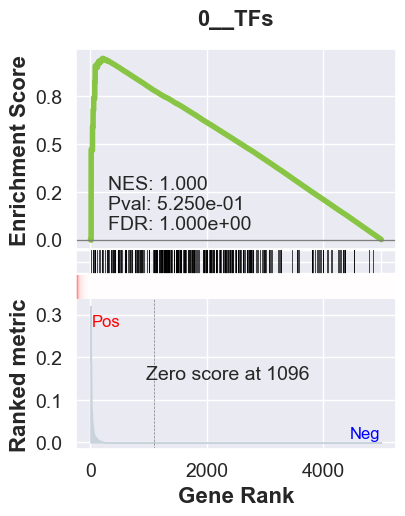

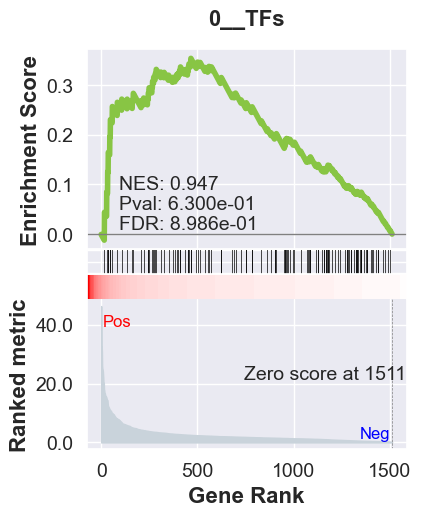

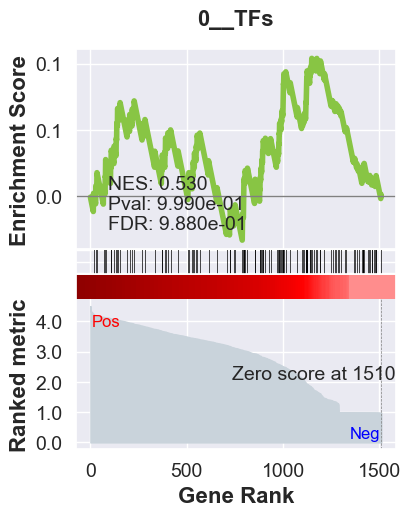

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2117 genes
intersection pct: 0.4234
precision:  0.0009433230227112625 
recall:  0.15979381443298968 
random precision: 0.0008516074089844582


 98%|█████████▊| 126/128 [00:00<00:00, 157.01it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 154.26it/s]


Average Precision (AP):  0.001073929650095888
Area Under Precision-Recall Curve (AUPRC):  0.000879486985502441
EPR: 1.81837962946922


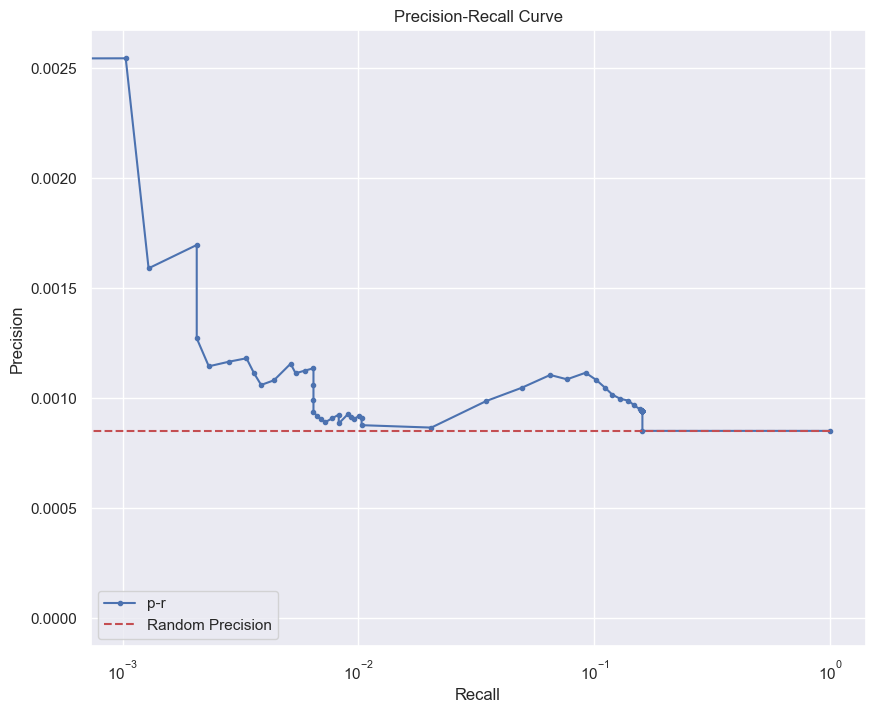

base enrichment
Top central genes: []


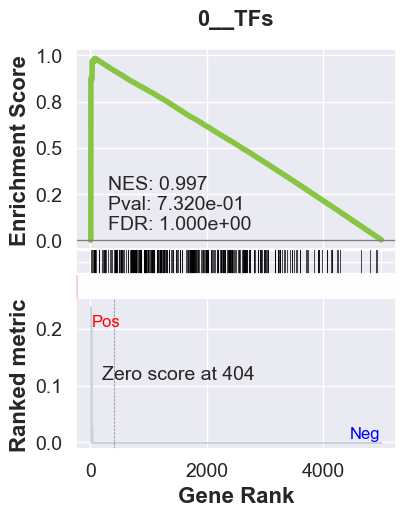

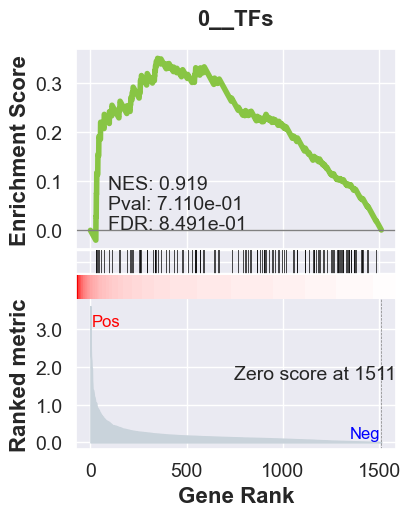

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2117 genes
intersection pct: 0.4234
precision:  0.005958427460315054 
recall:  0.10128865979381443 
random precision: 0.0008516074089844582


 99%|█████████▉| 127/128 [00:00<00:00, 157.68it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 155.78it/s]


Average Precision (AP):  0.002323576666709929
Area Under Precision-Recall Curve (AUPRC):  0.0014159437768026975
EPR: 6.413922525972374


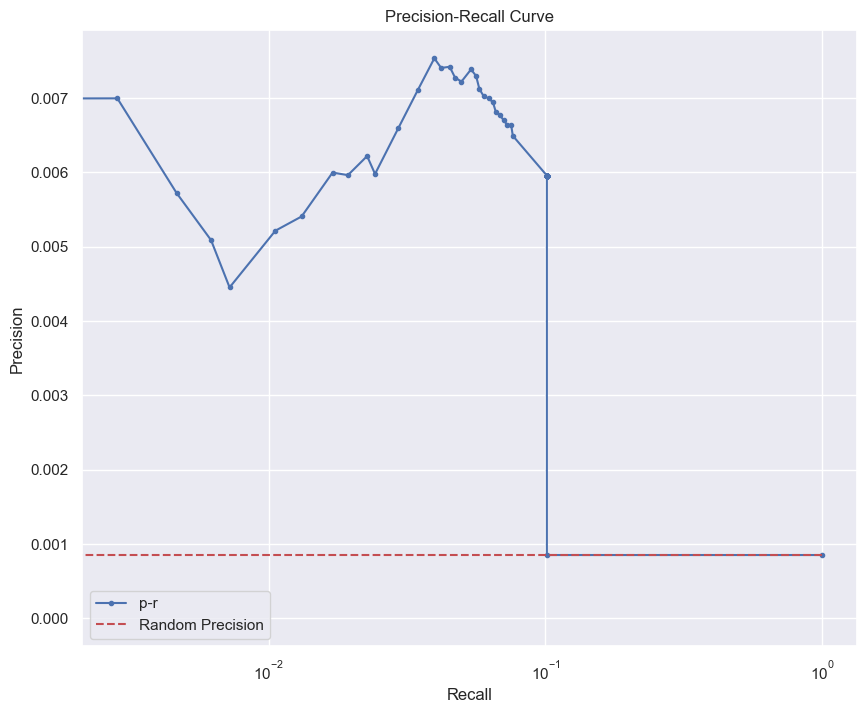

/tmp/ipykernel_136176/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment
Top central genes: []


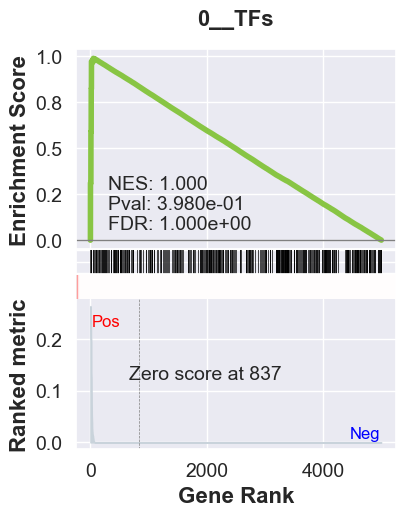

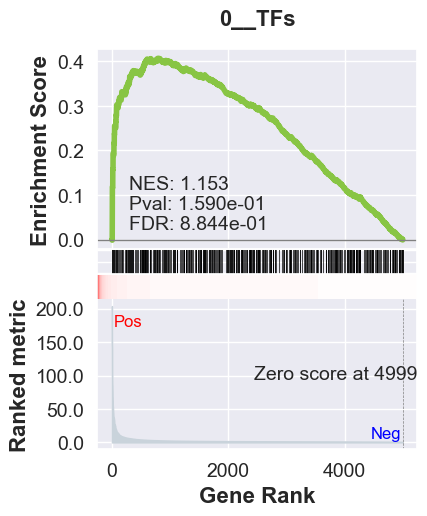

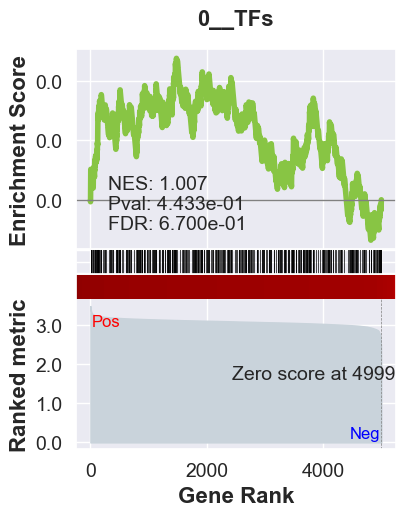

_________________________________________
TF specific enrichment
found some significant results for  5.172413793103448 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3636 genes
intersection pct: 0.7272
precision:  0.0013721925796491416 
recall:  0.993620765508139 
random precision: 0.0013758184621763415


 98%|█████████▊| 125/128 [00:02<00:00, 46.26it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 47.00it/s]


Average Precision (AP):  0.001444344630233324
Area Under Precision-Recall Curve (AUPRC):  0.0014427319336541057
EPR: 0.3191723376128248


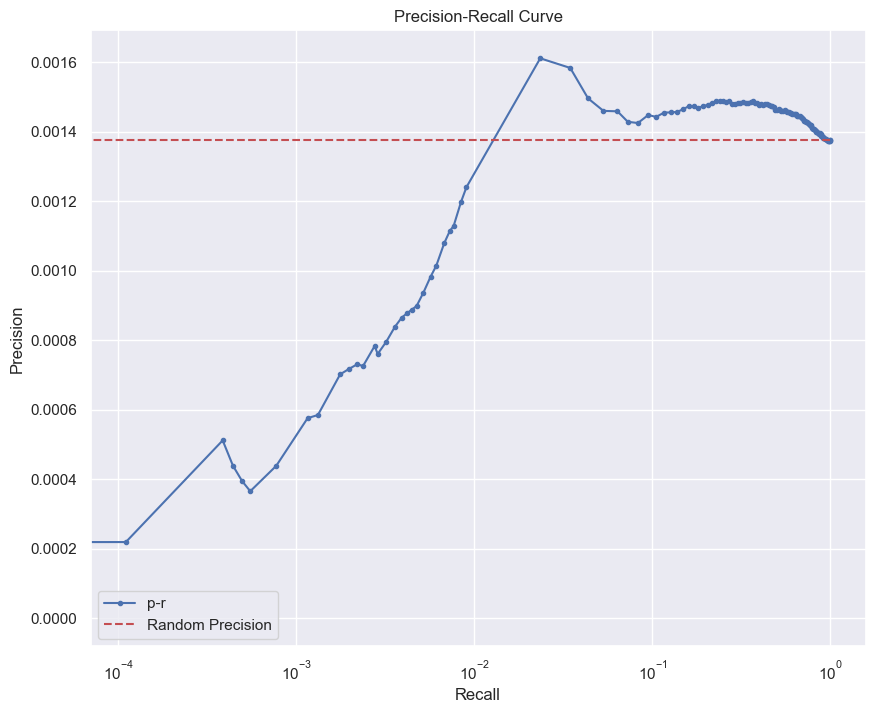

base enrichment
Top central genes: []


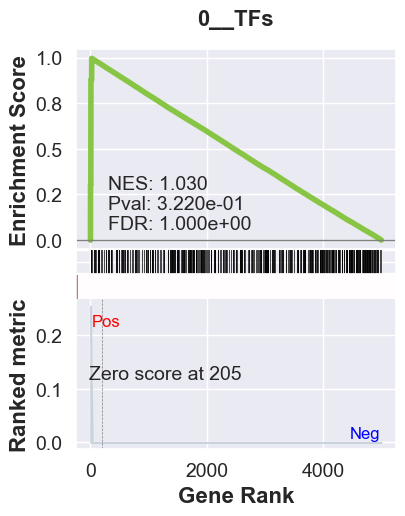

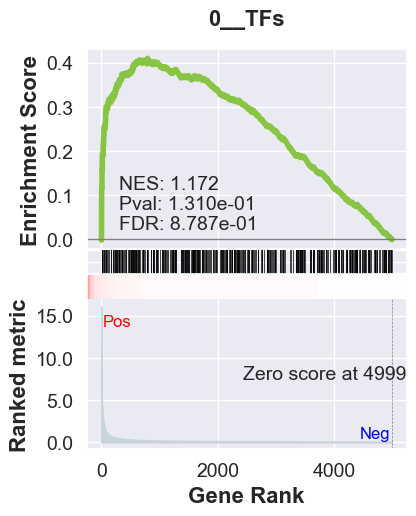

_________________________________________
TF specific enrichment
found some significant results for  3.4482758620689653 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3636 genes
intersection pct: 0.7272
precision:  0.006042083871179213 
recall:  0.42575890893092827 
random precision: 0.0013758184621763415


 98%|█████████▊| 126/128 [00:02<00:00, 47.03it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 49.10it/s]


Average Precision (AP):  0.004116772417212773
Area Under Precision-Recall Curve (AUPRC):  0.0035520465013251902
EPR: 5.174908996752878


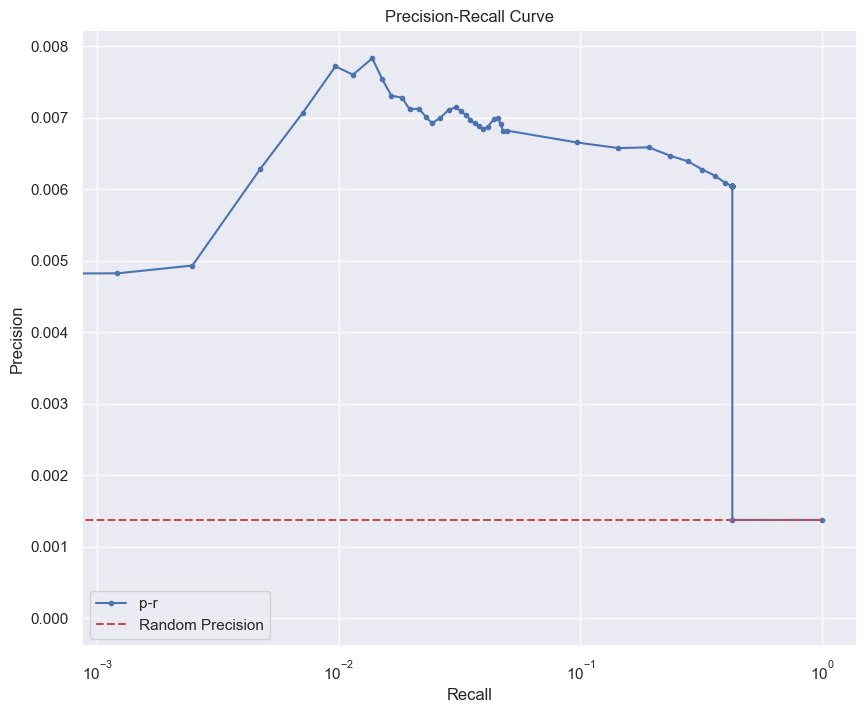

/tmp/ipykernel_136176/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment
Top central genes: []


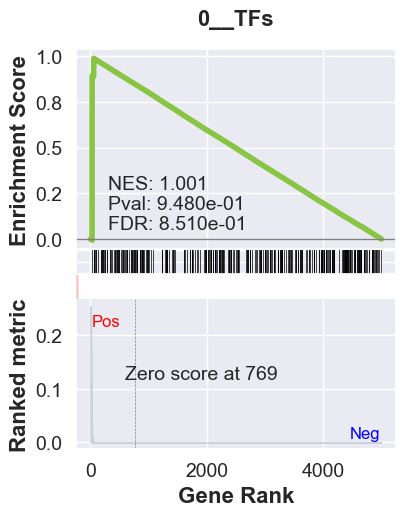

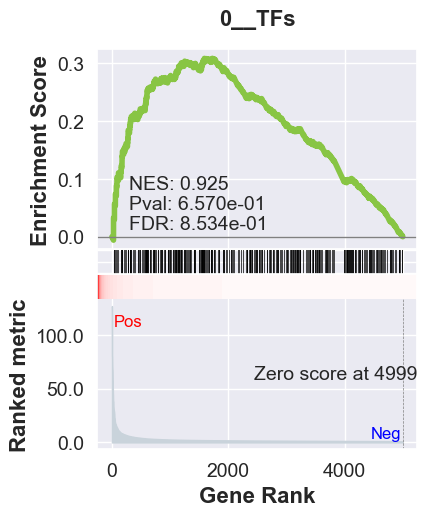

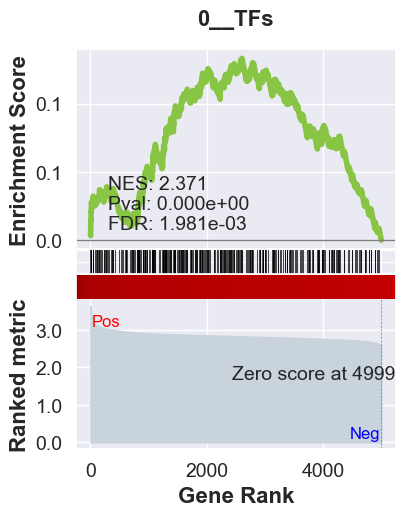

_________________________________________
TF specific enrichment
found some significant results for  3.5714285714285716 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3600 genes
intersection pct: 0.72
precision:  0.0008186247628743175 
recall:  1.0 
random precision: 0.0008187459479485043


 98%|█████████▊| 126/128 [00:02<00:00, 53.42it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 53.02it/s]


Average Precision (AP):  0.0008182082144211172
Area Under Precision-Recall Curve (AUPRC):  0.0008173646308112269
EPR: 0.575287927289365


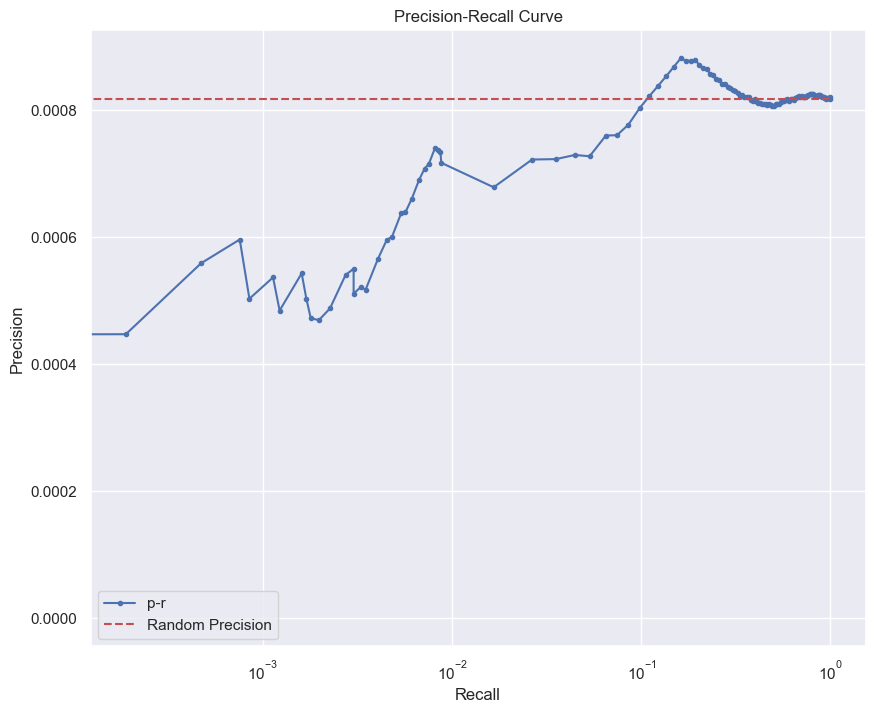

base enrichment
Top central genes: []


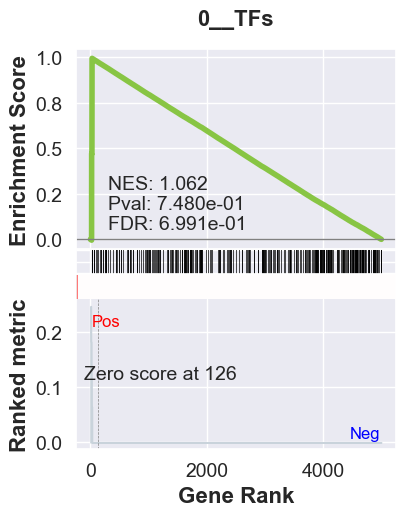

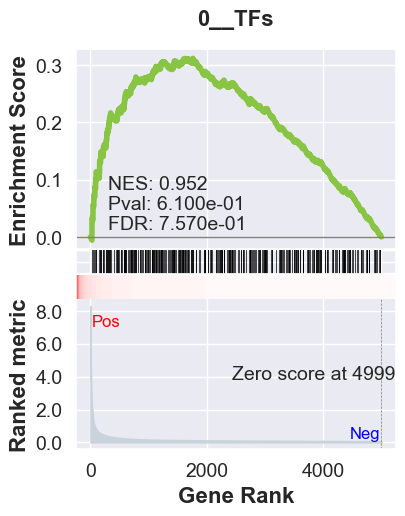

_________________________________________
TF specific enrichment
found some significant results for  3.5714285714285716 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3600 genes
intersection pct: 0.72
precision:  0.0029004011696182976 
recall:  0.277526395173454 
random precision: 0.0008187459479485043


 97%|█████████▋| 124/128 [00:02<00:00, 52.41it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 52.39it/s]


Average Precision (AP):  0.0018361814240844575
Area Under Precision-Recall Curve (AUPRC):  0.0014488174559834817
EPR: 4.516174679203505


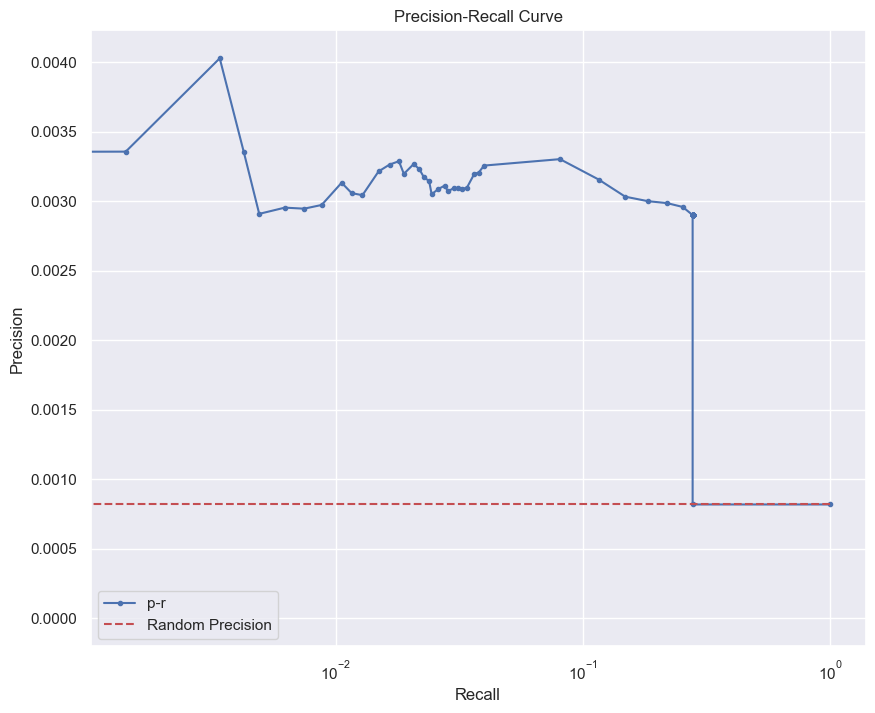

/tmp/ipykernel_136176/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment
Top central genes: []


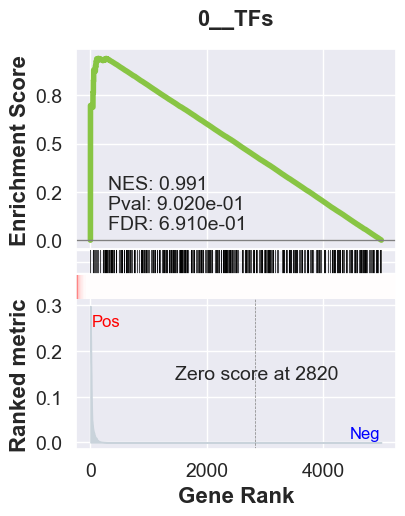

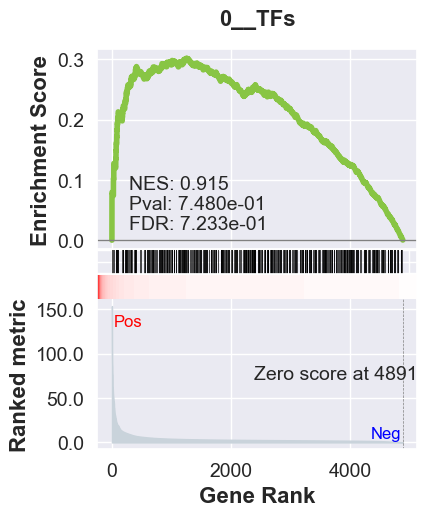

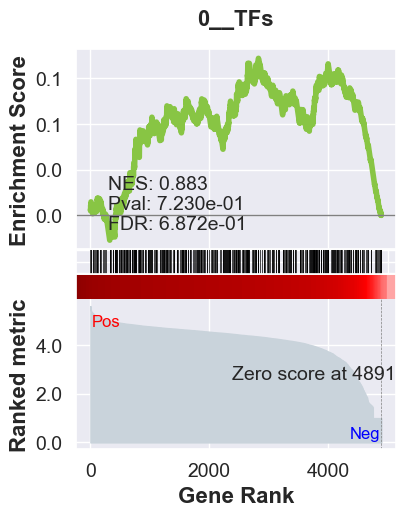

_________________________________________
TF specific enrichment
found some significant results for  6.666666666666667 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3357 genes
intersection pct: 0.6714
precision:  0.0007601662381513699 
recall:  0.8355088367794848 
random precision: 0.0007684119746226109


 98%|█████████▊| 126/128 [00:02<00:00, 61.69it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 61.69it/s]


Average Precision (AP):  0.0008264941668753561
Area Under Precision-Recall Curve (AUPRC):  0.0008247582233735535
EPR: 2.4104489378630936


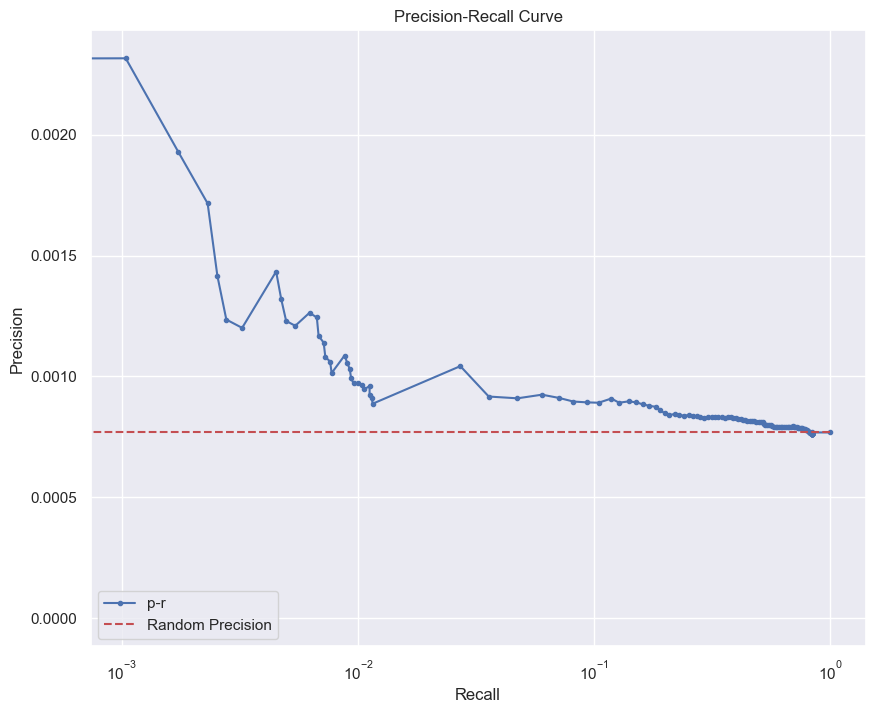

base enrichment
Top central genes: []


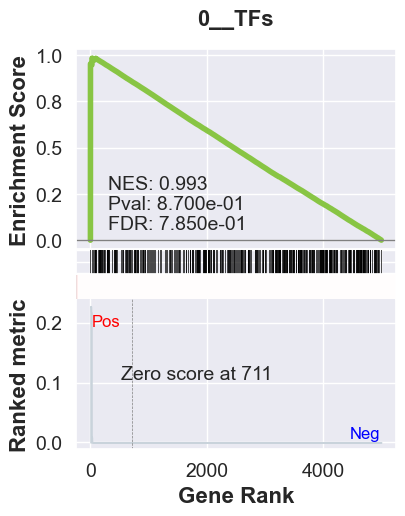

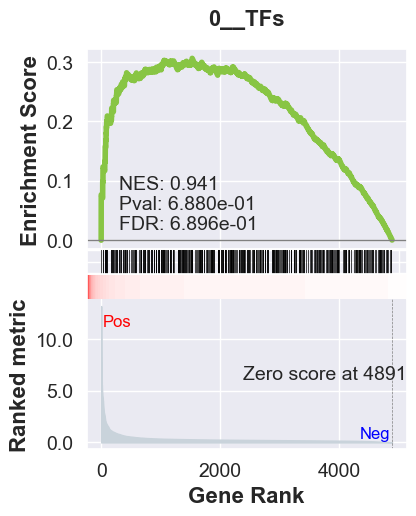

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3357 genes
intersection pct: 0.6714
precision:  0.0022571608744530783 
recall:  0.2683377613491972 
random precision: 0.0007684119746226109


 98%|█████████▊| 126/128 [00:02<00:00, 61.87it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 61.75it/s]


Average Precision (AP):  0.0014074203273641008
Area Under Precision-Recall Curve (AUPRC):  0.0011824447802817623
EPR: 3.6223802085127246


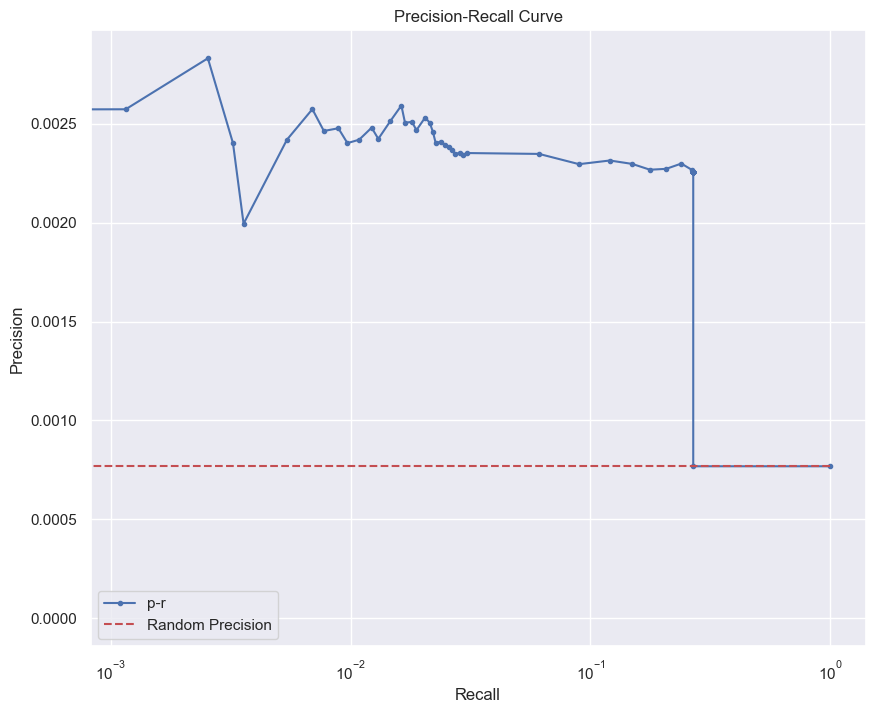

/tmp/ipykernel_136176/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment
Top central genes: []


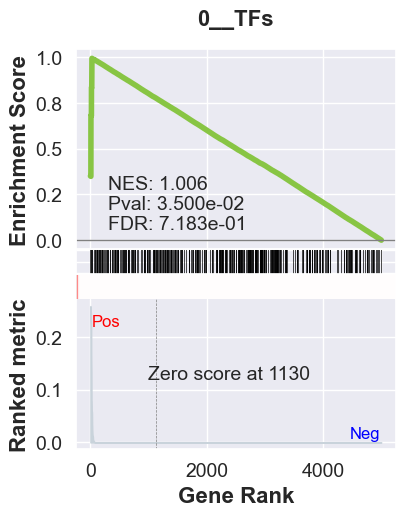

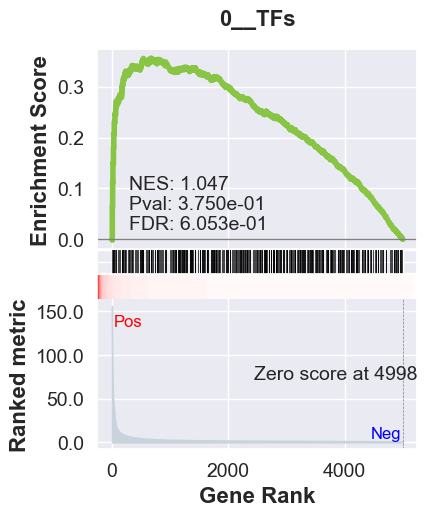

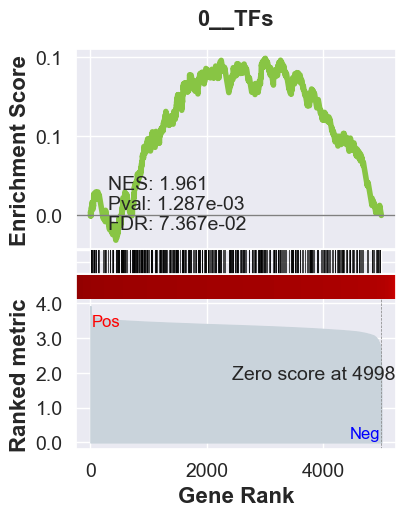

_________________________________________
TF specific enrichment
found some significant results for  3.5714285714285716 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3522 genes
intersection pct: 0.7044
precision:  0.0006745555736545549 
recall:  0.9962802975761939 
random precision: 0.0006720446365370686


 98%|█████████▊| 126/128 [00:02<00:00, 56.31it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 55.57it/s]


Average Precision (AP):  0.000721868651571475
Area Under Precision-Recall Curve (AUPRC):  0.0007177377535588938
EPR: 2.504685073039941


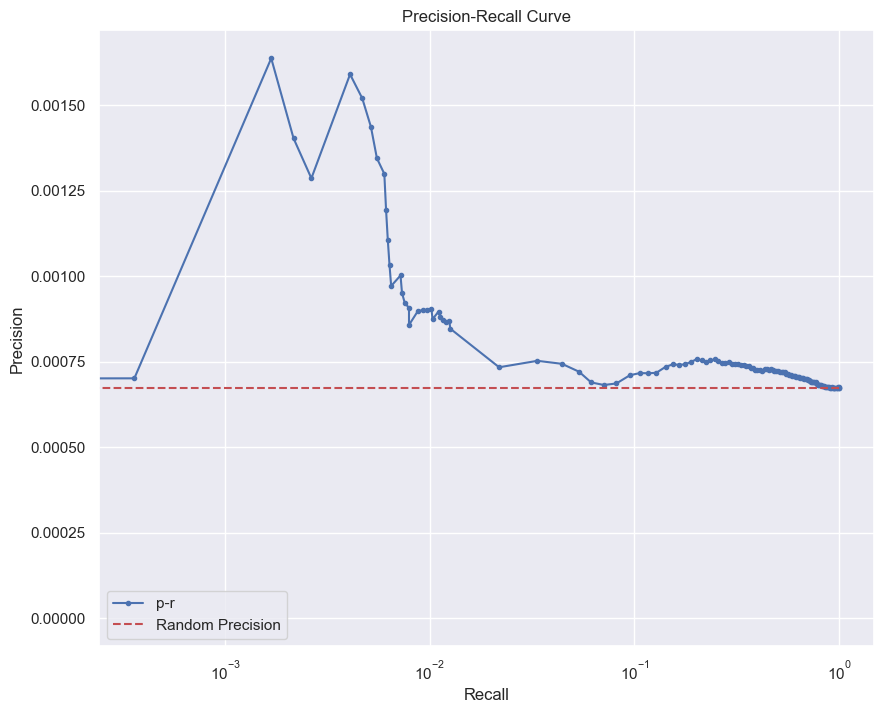

base enrichment
Top central genes: []


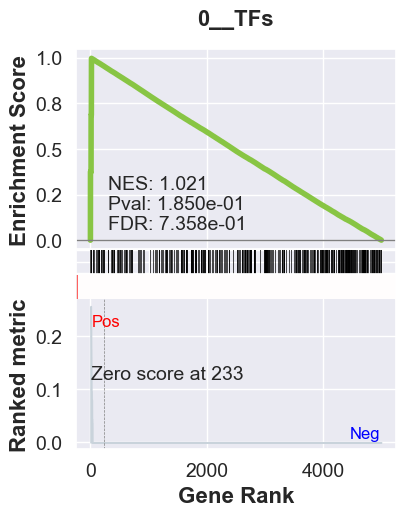

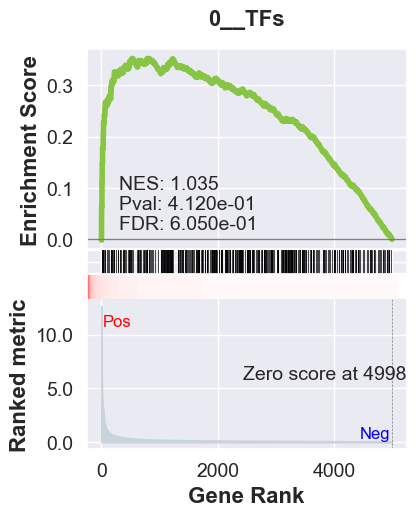

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3522 genes
intersection pct: 0.7044
precision:  0.0016882851250234366 
recall:  0.2377009839212863 
random precision: 0.0006720446365370686


 98%|█████████▊| 126/128 [00:02<00:00, 56.10it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 55.41it/s]


Average Precision (AP):  0.0011474613164087115
Area Under Precision-Recall Curve (AUPRC):  0.0009370981295738357
EPR: 3.7633596455322116


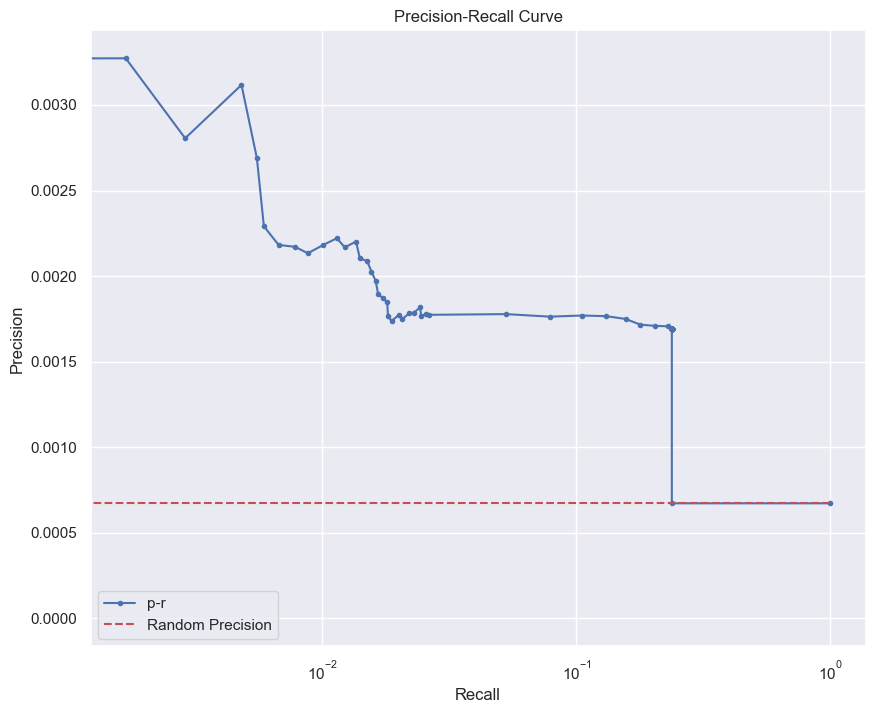

/tmp/ipykernel_136176/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment
Top central genes: []


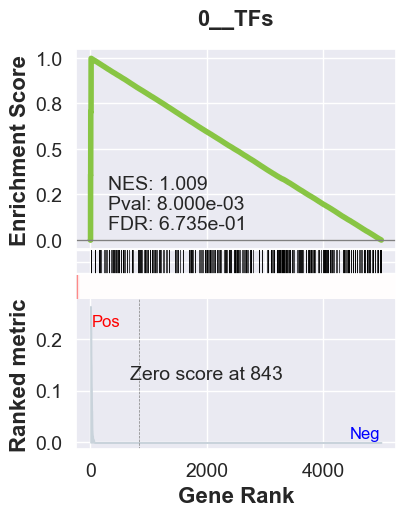

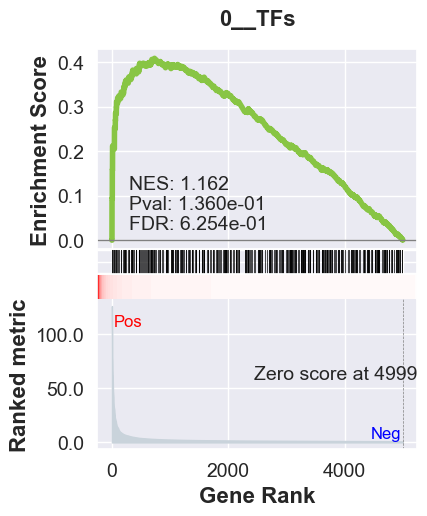

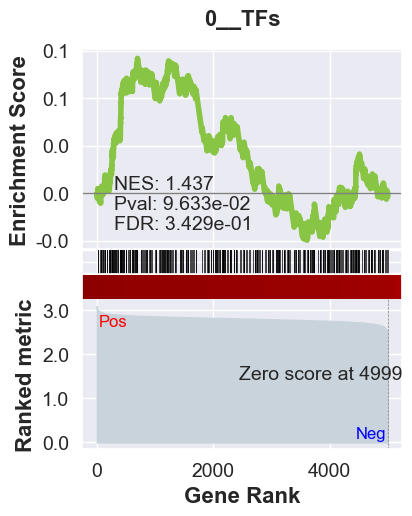

_________________________________________
TF specific enrichment
found some significant results for  6.0606060606060606 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3522 genes
intersection pct: 0.7044
precision:  0.0007677649430538696 
recall:  0.9994747899159664 
random precision: 0.000767682378189692


 98%|█████████▊| 126/128 [00:02<00:00, 56.13it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 54.88it/s]


Average Precision (AP):  0.0008403631162377946
Area Under Precision-Recall Curve (AUPRC):  0.0008387606484916029
EPR: 1.2319087093494971


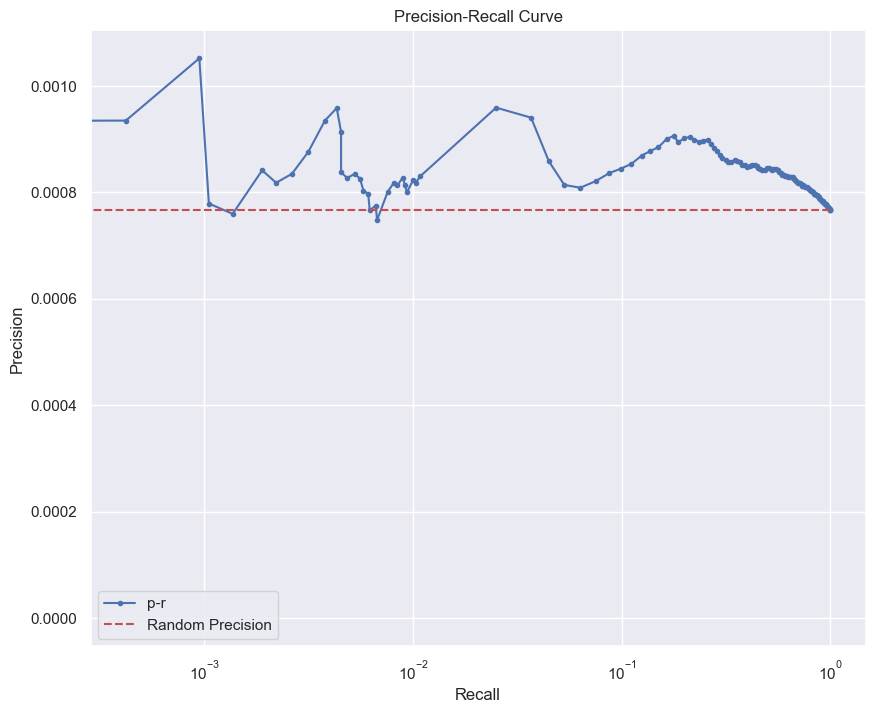

base enrichment
Top central genes: []


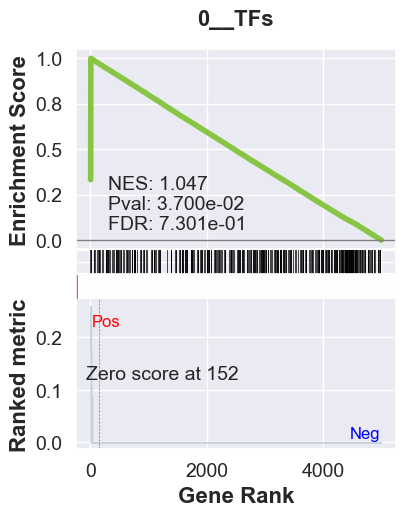

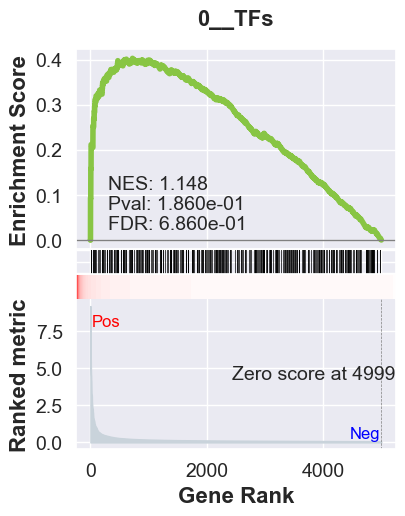

_________________________________________
TF specific enrichment
found some significant results for  3.0303030303030303 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3522 genes
intersection pct: 0.7044
precision:  0.0028294451748818775 
recall:  0.31376050420168067 
random precision: 0.000767682378189692


 98%|█████████▊| 126/128 [00:02<00:00, 53.92it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 53.57it/s]


Average Precision (AP):  0.0018562181526598947
Area Under Precision-Recall Curve (AUPRC):  0.0015209249904224028
EPR: 5.233269391163381


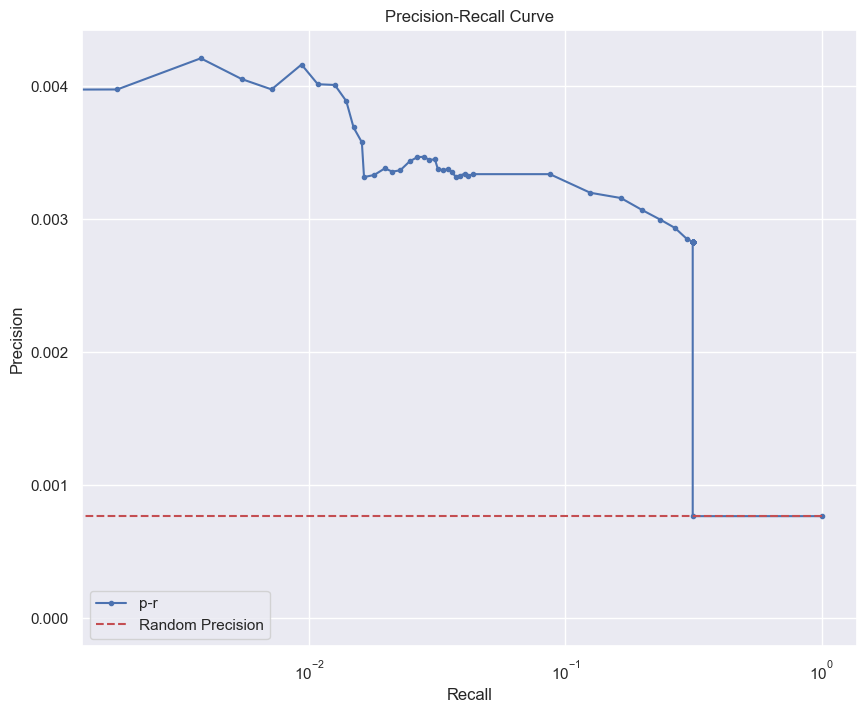

/tmp/ipykernel_136176/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment
Top central genes: []


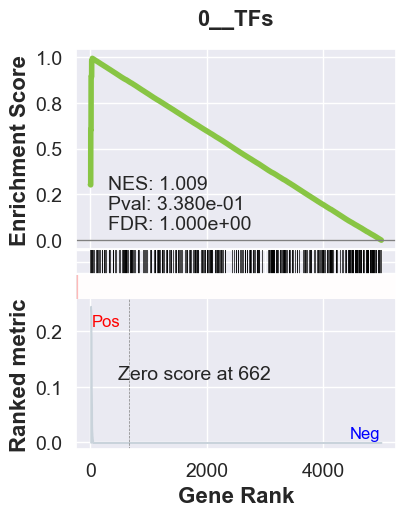

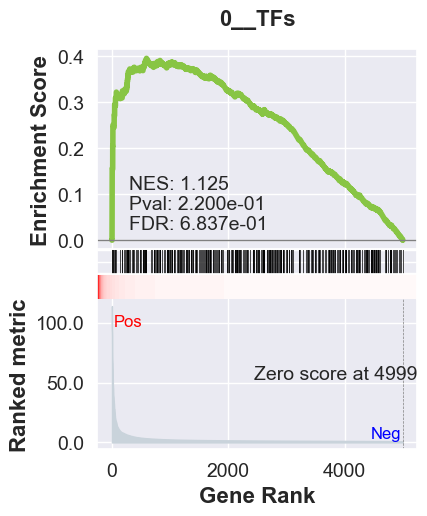

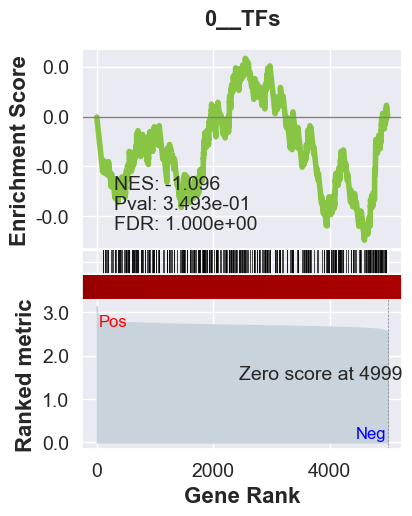

_________________________________________
TF specific enrichment
found some significant results for  15.384615384615385 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3551 genes
intersection pct: 0.7102
precision:  0.0010249412685020178 
recall:  1.0 
random precision: 0.0010252220164127543


 98%|█████████▊| 126/128 [00:02<00:00, 54.29it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 54.11it/s]


Average Precision (AP):  0.0010453890637975285
Area Under Precision-Recall Curve (AUPRC):  0.0010448166086325136
EPR: 0.45232283350473135


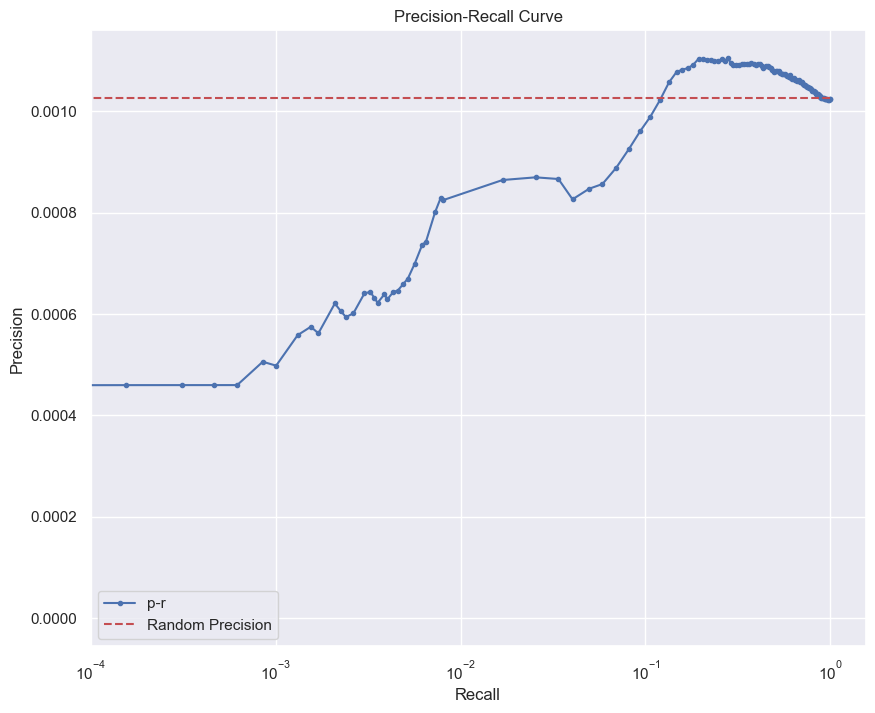

base enrichment
Top central genes: []


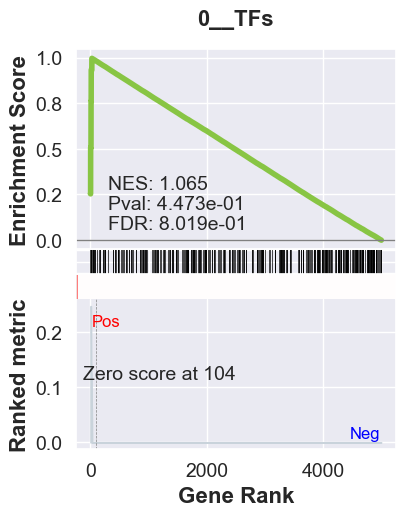

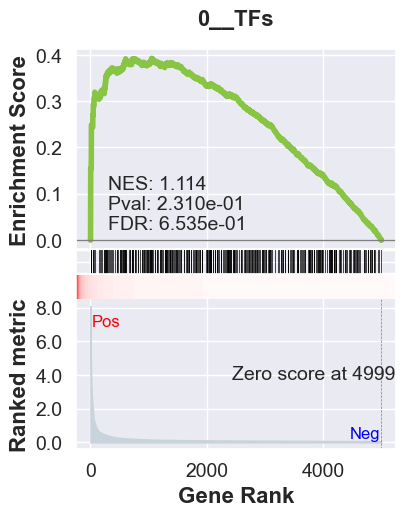

_________________________________________
TF specific enrichment
found some significant results for  15.384615384615385 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3551 genes
intersection pct: 0.7102
precision:  0.003778232872841966 
recall:  0.3166202414113278 
random precision: 0.0010252220164127543


 98%|█████████▊| 126/128 [00:02<00:00, 53.83it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 52.96it/s]


Average Precision (AP):  0.0023734142260153157
Area Under Precision-Recall Curve (AUPRC):  0.0019484128347868515
EPR: 4.331215933849695


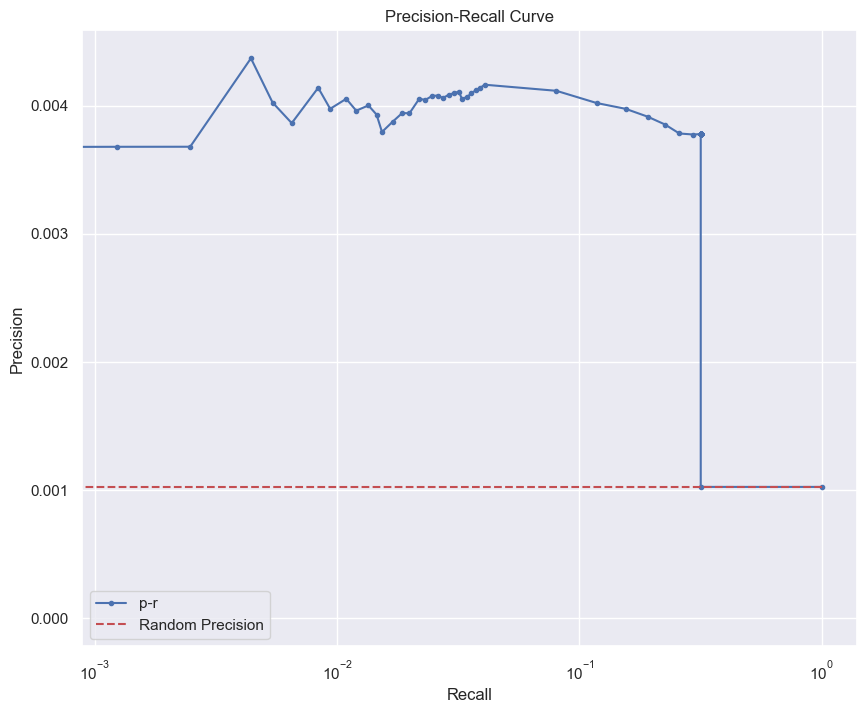

/tmp/ipykernel_136176/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/123 [00:00<?, ?it/s]

base enrichment
Top central genes: []


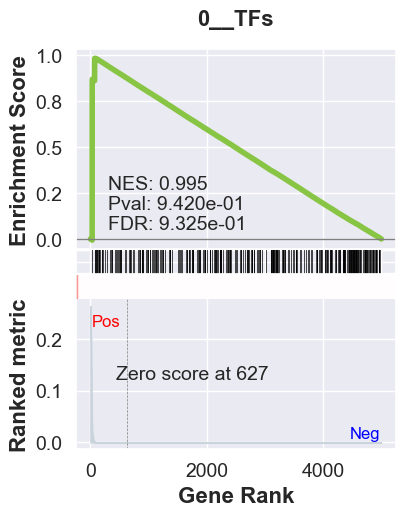

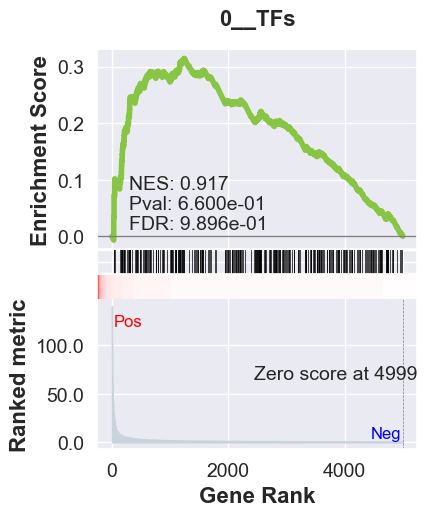

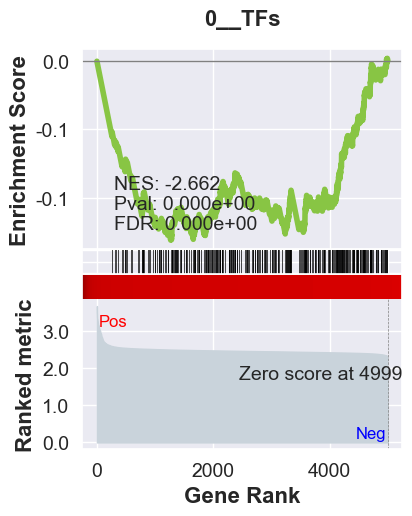

_________________________________________
TF specific enrichment
found some significant results for  16.666666666666668 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3675 genes
intersection pct: 0.735
precision:  0.0009556848146112396 
recall:  0.9961912164788185 
random precision: 0.0009528253326371376


 97%|█████████▋| 124/128 [00:02<00:00, 51.30it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 50.22it/s]


Average Precision (AP):  0.0010016370215480198
Area Under Precision-Recall Curve (AUPRC):  0.0010004250542147996
EPR: 1.3878627055162847


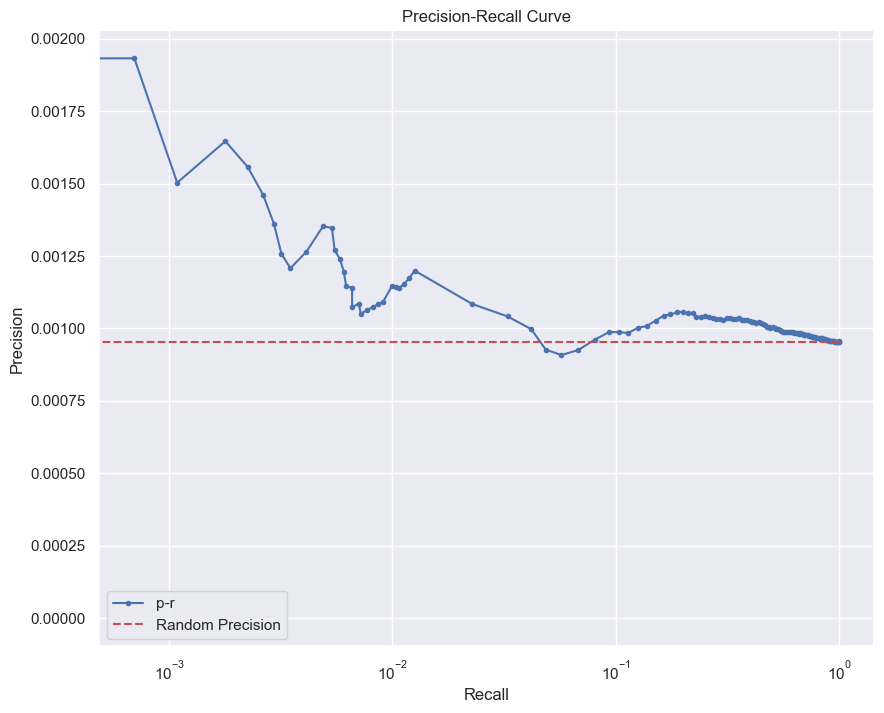

base enrichment
Top central genes: []


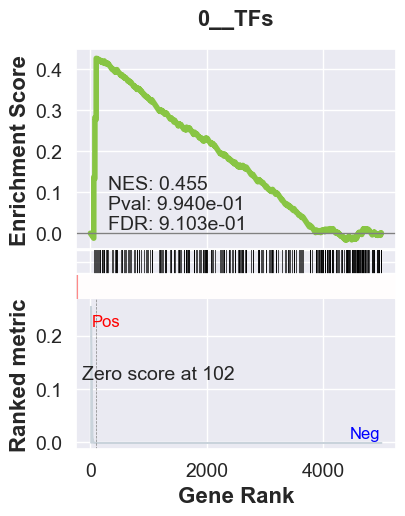

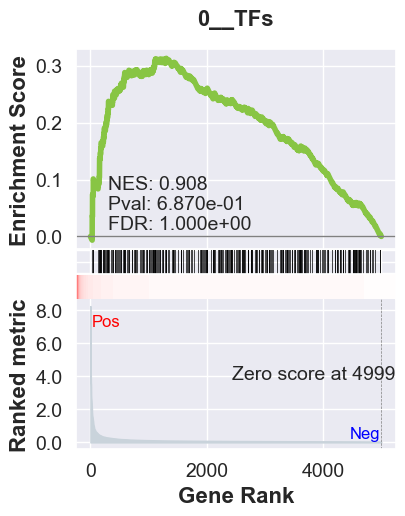

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3675 genes
intersection pct: 0.735
precision:  0.003120771865983059 
recall:  0.22984842596191216 
random precision: 0.0009528253326371376


 98%|█████████▊| 125/128 [00:02<00:00, 47.77it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 46.51it/s]


Average Precision (AP):  0.0018613947044491248
Area Under Precision-Recall Curve (AUPRC):  0.0015078265702467637
EPR: 5.346426544189453


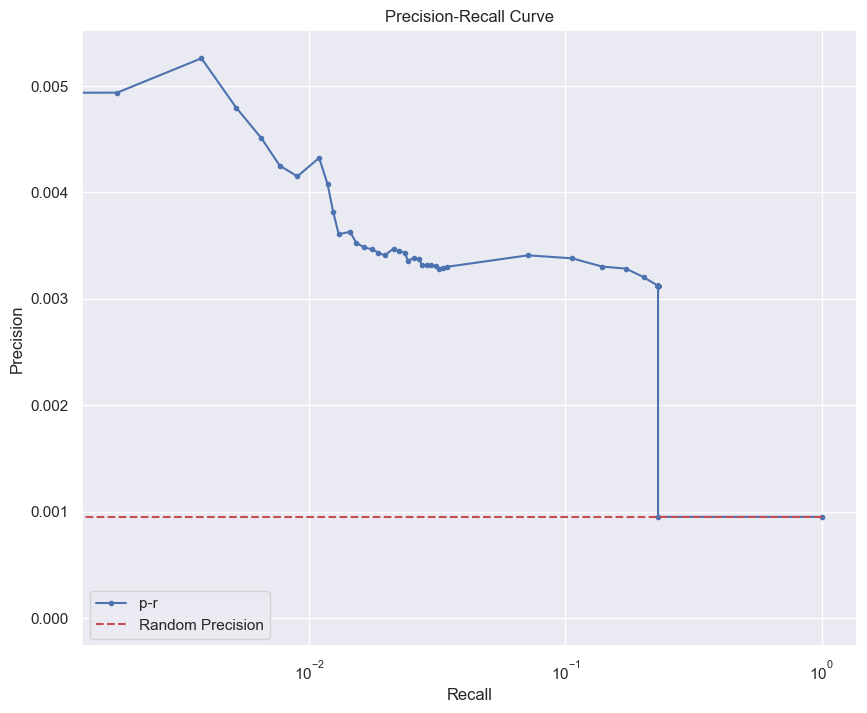

/tmp/ipykernel_136176/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/58 [00:00<?, ?it/s]

base enrichment
Top central genes: []


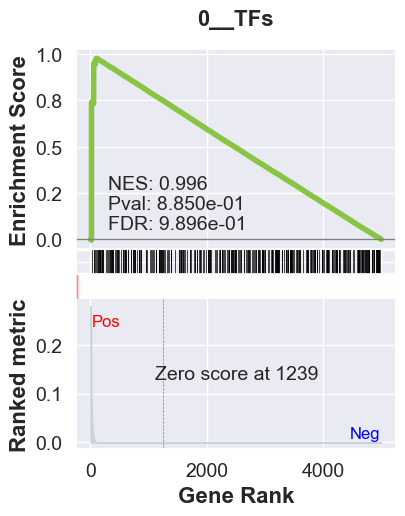

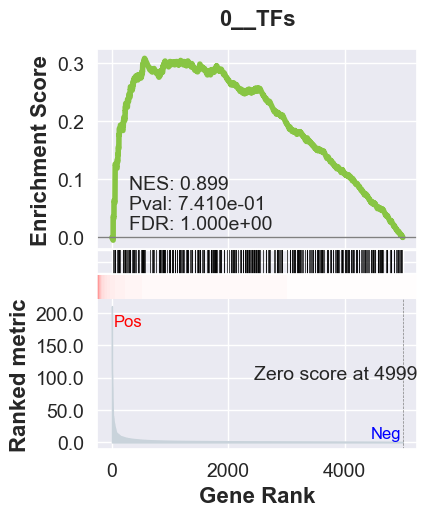

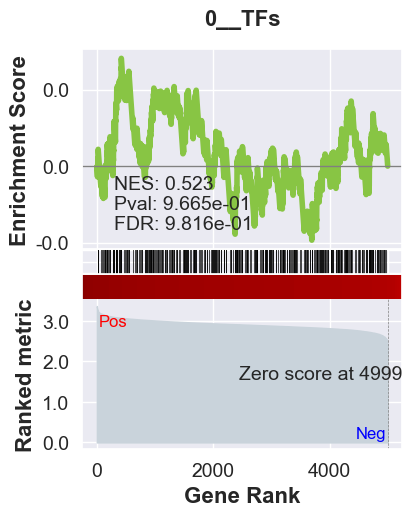

_________________________________________
TF specific enrichment
found some significant results for  2.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3646 genes
intersection pct: 0.7292
precision:  0.0014347636620787227 
recall:  0.9966354747134897 
random precision: 0.0014313372717305998


 99%|█████████▉| 127/128 [00:02<00:00, 50.66it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 50.04it/s]


Average Precision (AP):  0.0015361571579013908
Area Under Precision-Recall Curve (AUPRC):  0.0015358892797313747
EPR: 1.3603507613713584


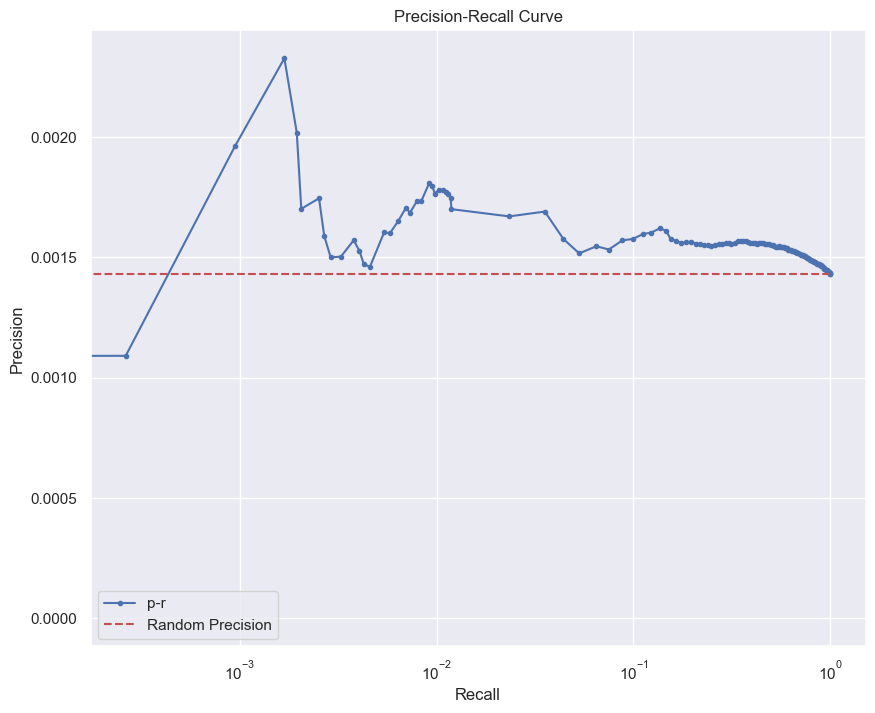

base enrichment
Top central genes: []


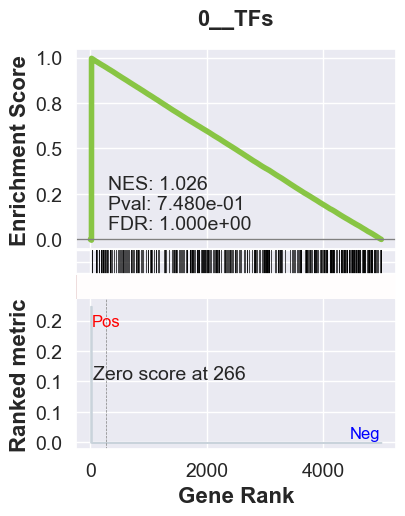

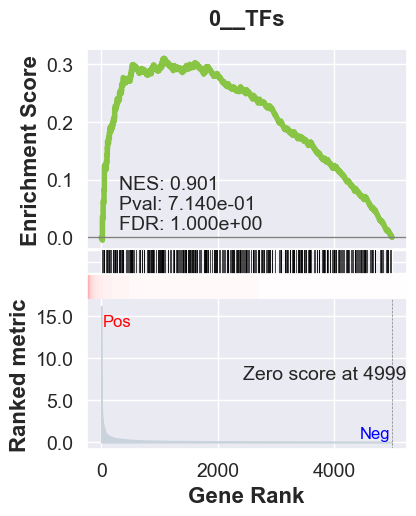

_________________________________________
TF specific enrichment
found some significant results for  4.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3646 genes
intersection pct: 0.7292
precision:  0.006668683336665966 
recall:  0.4102618021238566 
random precision: 0.0014313372717305998


 99%|█████████▉| 127/128 [00:02<00:00, 49.33it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 50.12it/s]


Average Precision (AP):  0.004478667900545145
Area Under Precision-Recall Curve (AUPRC):  0.0038869068705145353
EPR: 6.224981154944492


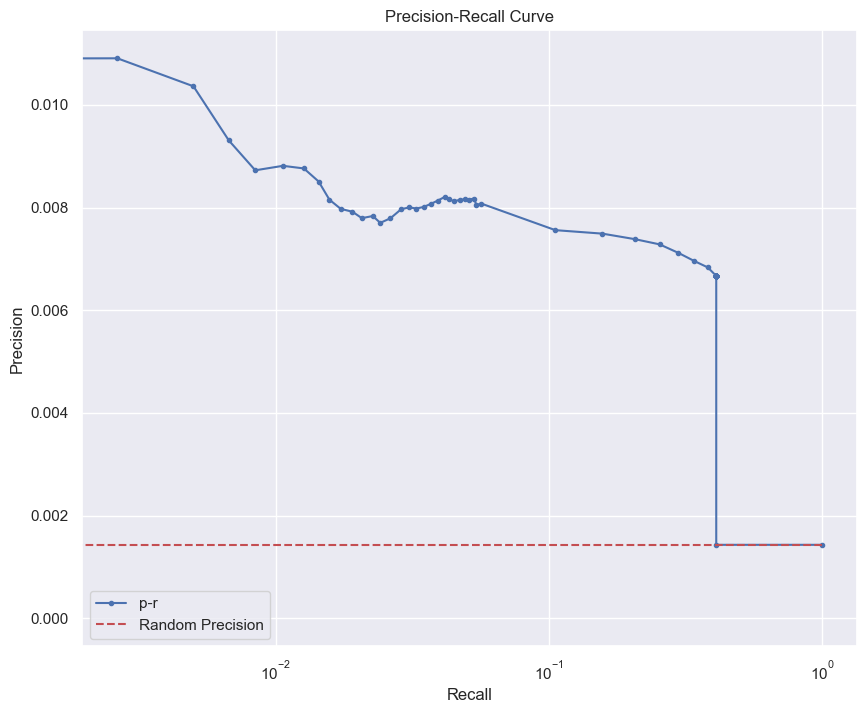

/tmp/ipykernel_136176/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/58 [00:00<?, ?it/s]

base enrichment
Top central genes: []


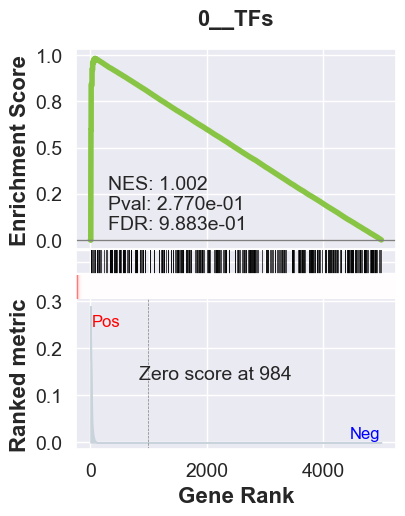

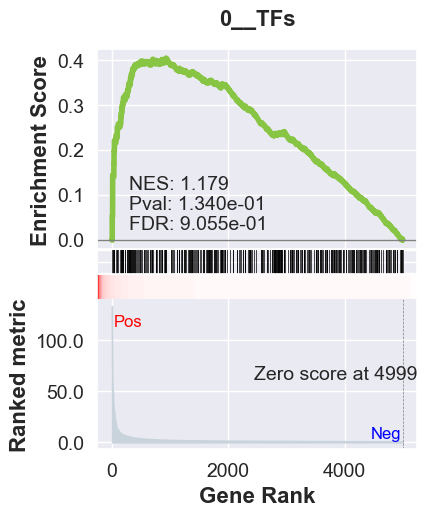

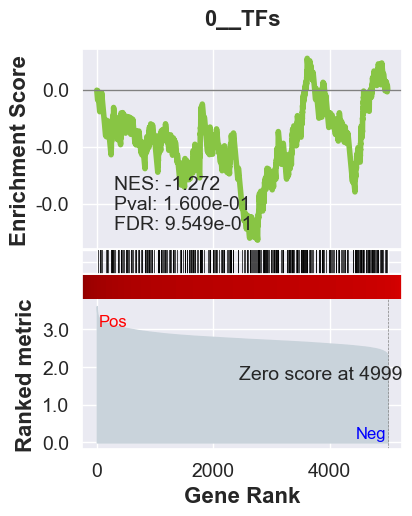

_________________________________________
TF specific enrichment
found some significant results for  9.090909090909092 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3763 genes
intersection pct: 0.7526
precision:  0.0018308921556396945 
recall:  0.9928304359557492 
random precision: 0.0018325979065590518


 98%|█████████▊| 125/128 [00:02<00:00, 47.03it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 46.77it/s]


Average Precision (AP):  0.00204496529615235
Area Under Precision-Recall Curve (AUPRC):  0.002041084591377294
EPR: 1.5808700771140343


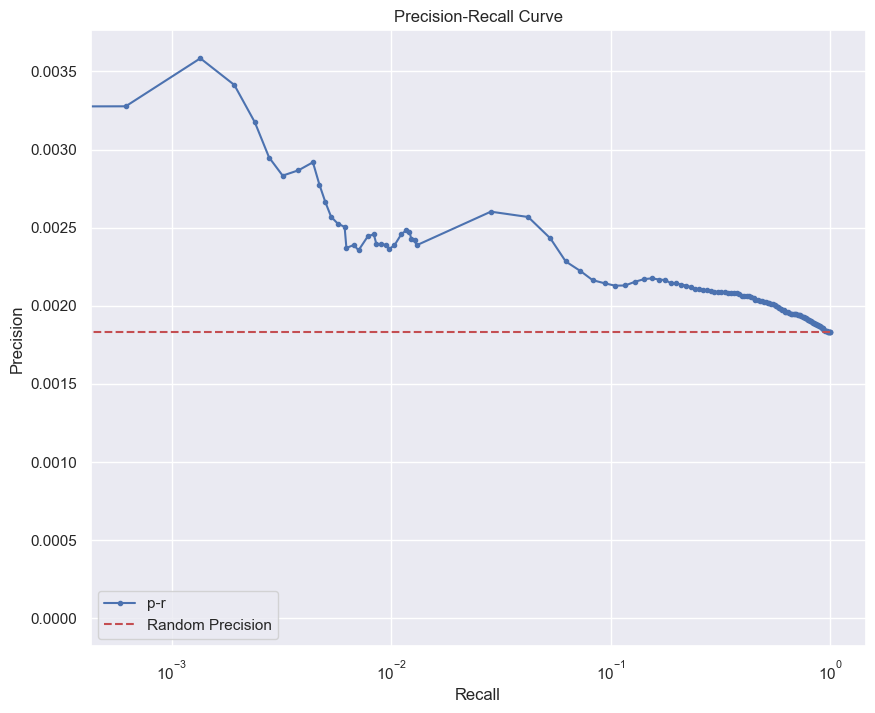

base enrichment
Top central genes: []


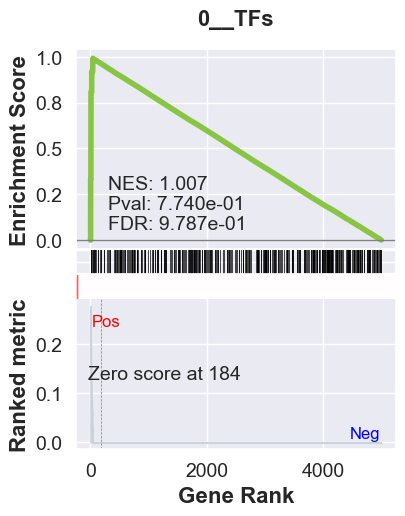

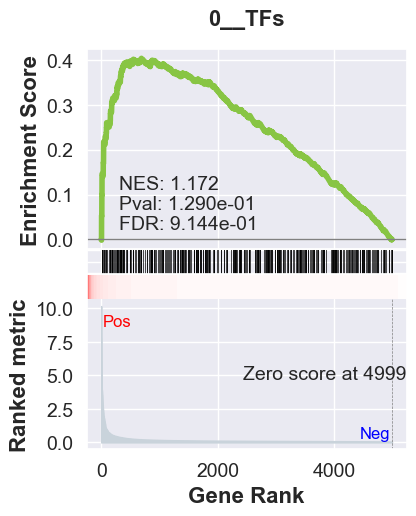

_________________________________________
TF specific enrichment
found some significant results for  1.5151515151515151 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3763 genes
intersection pct: 0.7526
precision:  0.009170400982279404 
recall:  0.4502563311876036 
random precision: 0.0018325979065590518


 98%|█████████▊| 125/128 [00:02<00:00, 46.57it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 46.67it/s]


Average Precision (AP):  0.0064994641277715355
Area Under Precision-Recall Curve (AUPRC):  0.005690313718575843
EPR: 7.514812562386952


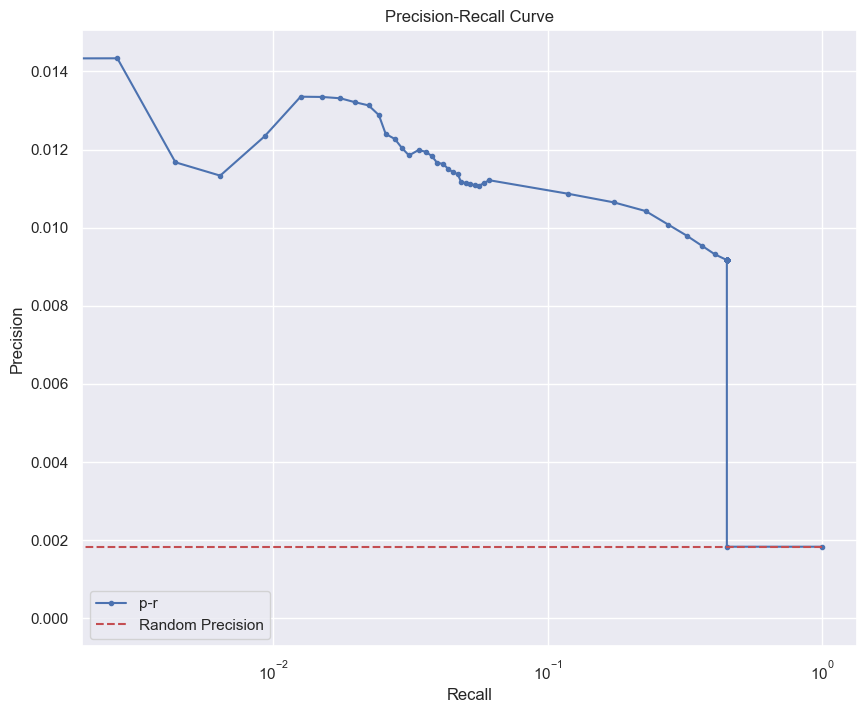

In [6]:
adata.var['ensembl_id'] = adata.var.index
adata = adata[adata.X.sum(1) > 500, adata.var.index.isin(gene_mapping_dict.keys())]
sc.tl.rank_genes_groups(
    adata, groupby="cell_type"
)
metrics = {}
shapes = []
for celltype in CELLTYPES:
    to_use = adata.uns["rank_genes_groups"]["names"][celltype][
        : NUM_GENES
    ].tolist()
    subadata = adata[adata.obs.cell_type == celltype][:MAXCELLS, adata.var.index.isin(to_use)]
    grn = compute_geneformer_network(
        subadata)
    grn.var.index = make_index_unique(
        grn.var['symbol'].astype(str))
    metrics['geneformer_'+celltype] = BenGRN(grn,
                                            do_auc=True, doplot=True).scprint_benchmark()
    grn.varp['GRN'][~grn.var.isTF, :] = 0
    grn.var.index = make_index_unique(
        grn.var['symbol'].astype(str))
    metrics['geneformer_tf_'+celltype] = BenGRN(grn,
                                         do_auc=True, doplot=True).scprint_benchmark()
    shapes.append(grn.shape[1])

In [7]:
metrics

{'geneformer_retinal rod cell': {'TF_enr': False,
  'enriched_terms_Targets': ['celltype.gmt__Cone photoreceptor cells',
   'celltype.gmt__Rod photoreceptor cells'],
  'significant_enriched_TFtargets': 0.0,
  'precision': 0.0009433230227112625,
  'recall': 0.15979381443298968,
  'rand_precision': 0.0008516074089844582,
  'auprc': 0.000879486985502441,
  'ap': 0.001073929650095888,
  'epr': 1.81837962946922},
 'geneformer_TF_retinal rod cell': {'TF_enr': False,
  'significant_enriched_TFtargets': 0.0,
  'precision': 0.005958427460315054,
  'recall': 0.10128865979381443,
  'rand_precision': 0.0008516074089844582,
  'auprc': 0.0014159437768026975,
  'ap': 0.002323576666709929,
  'epr': 6.413922525972374},
 'geneformer_Mueller cell': {'TF_enr': False,
  'significant_enriched_TFtargets': 5.172413793103448,
  'precision': 0.0013721925796491416,
  'recall': 0.993620765508139,
  'rand_precision': 0.0013758184621763415,
  'auprc': 0.0014427319336541057,
  'ap': 0.001444344630233324,
  'epr': 0.

In [11]:
shapes

[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]

In [9]:
True
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
True
False
False
False

True

In [25]:
# df 

name       EPR     AUPRC      RAND    TF_targ  TF_enr  \
0         retinal rod cell  1.818380  0.000879  0.000852   0.000000   False   
1         retinal rod cell  6.413923  0.001416  0.000852   0.000000   False   
2             Mueller cell  0.319172  0.001443  0.001376   5.172414   False   
3             Mueller cell  5.174909  0.003552  0.001376   3.448276   False   
4            amacrine cell  0.575288  0.000817  0.000819   3.571429    True   
5            amacrine cell  4.516175  0.001449  0.000819   3.571429   False   
6          ON-bipolar cell  2.410449  0.000825  0.000768   6.666667   False   
7          ON-bipolar cell  3.622380  0.001182  0.000768   0.000000   False   
8         rod bipolar cell  2.504685  0.000718  0.000672   3.571429    True   
9         rod bipolar cell  3.763360  0.000937  0.000672   0.000000   False   
10       retinal cone cell  1.231909  0.000839  0.000768   6.060606   False   
11       retinal cone cell  5.233269  0.001521  0.000768   3.030303   False   
12  retina horizontal cell  0.452323  0.001045  0.001025  15.384615   False   
13  retina horizontal cell  4.331216  0.001948  0.001025  15.384615   False   
14   retinal ganglion cell  1.387863  0.001000  0.000953  16.666667    True   
15   retinal ganglion cell  5.346427  0.001508  0.000953   0.000000   False   
16               astrocyte  1.360351  0.001536  0.001431   2.000000   False   
17               astrocyte  6.224981  0.003887  0.001431   4.000000   False   
18         microglial cell  1.580870  0.002041  0.001833   9.090909   False   
19         microglial cell  7.514813  0.005690  0.001833   1.515152   False   

    TF_only  
0     False  
1     False  
2     False  
3     False  
4     False  
5     False  
6     False  
7     False  
8     False  
9     False  
10    False  
11    False  
12    False  
13    False  
14    False  
15    False  
16    False  
17    False  
18    False  
19    False

In [23]:
res = []
for k, v in metrics.items():
    res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

name       EPR     AUPRC      RAND    TF_targ  TF_enr  \
0         retinal rod cell  1.818380  0.000879  0.000852   0.000000   False   
1         retinal rod cell  6.413923  0.001416  0.000852   0.000000   False   
2             Mueller cell  0.319172  0.001443  0.001376   5.172414   False   
3             Mueller cell  5.174909  0.003552  0.001376   3.448276   False   
4            amacrine cell  0.575288  0.000817  0.000819   3.571429    True   
5            amacrine cell  4.516175  0.001449  0.000819   3.571429   False   
6          ON-bipolar cell  2.410449  0.000825  0.000768   6.666667   False   
7          ON-bipolar cell  3.622380  0.001182  0.000768   0.000000   False   
8         rod bipolar cell  2.504685  0.000718  0.000672   3.571429    True   
9         rod bipolar cell  3.763360  0.000937  0.000672   0.000000   False   
10       retinal cone cell  1.231909  0.000839  0.000768   6.060606   False   
11       retinal cone cell  5.233269  0.001521  0.000768   3.030303   False   
12  retina horizontal cell  0.452323  0.001045  0.001025  15.384615   False   
13  retina horizontal cell  4.331216  0.001948  0.001025  15.384615   False   
14   retinal ganglion cell  1.387863  0.001000  0.000953  16.666667    True   
15   retinal ganglion cell  5.346427  0.001508  0.000953   0.000000   False   
16               astrocyte  1.360351  0.001536  0.001431   2.000000   False   
17               astrocyte  6.224981  0.003887  0.001431   4.000000   False   
18         microglial cell  1.580870  0.002041  0.001833   9.090909   False   
19         microglial cell  7.514813  0.005690  0.001833   1.515152   False   

    TF_only  
0     False  
1     False  
2     False  
3     False  
4     False  
5     False  
6     False  
7     False  
8     False  
9     False  
10    False  
11    False  
12    False  
13    False  
14    False  
15    False  
16    False  
17    False  
18    False  
19    False

In [24]:
df

name       EPR     AUPRC      RAND    TF_targ  TF_enr  \
0         retinal rod cell  1.818380  0.000879  0.000852   0.000000   False   
1         retinal rod cell  6.413923  0.001416  0.000852   0.000000   False   
2             Mueller cell  0.319172  0.001443  0.001376   5.172414   False   
3             Mueller cell  5.174909  0.003552  0.001376   3.448276   False   
4            amacrine cell  0.575288  0.000817  0.000819   3.571429    True   
5            amacrine cell  4.516175  0.001449  0.000819   3.571429   False   
6          ON-bipolar cell  2.410449  0.000825  0.000768   6.666667   False   
7          ON-bipolar cell  3.622380  0.001182  0.000768   0.000000   False   
8         rod bipolar cell  2.504685  0.000718  0.000672   3.571429    True   
9         rod bipolar cell  3.763360  0.000937  0.000672   0.000000   False   
10       retinal cone cell  1.231909  0.000839  0.000768   6.060606   False   
11       retinal cone cell  5.233269  0.001521  0.000768   3.030303   False   
12  retina horizontal cell  0.452323  0.001045  0.001025  15.384615   False   
13  retina horizontal cell  4.331216  0.001948  0.001025  15.384615   False   
14   retinal ganglion cell  1.387863  0.001000  0.000953  16.666667    True   
15   retinal ganglion cell  5.346427  0.001508  0.000953   0.000000   False   
16               astrocyte  1.360351  0.001536  0.001431   2.000000   False   
17               astrocyte  6.224981  0.003887  0.001431   4.000000   False   
18         microglial cell  1.580870  0.002041  0.001833   9.090909   False   
19         microglial cell  7.514813  0.005690  0.001833   1.515152   False   

    TF_only  
0     False  
1     False  
2     False  
3     False  
4     False  
5     False  
6     False  
7     False  
8     False  
9     False  
10    False  
11    False  
12    False  
13    False  
14    False  
15    False  
16    False  
17    False  
18    False  
19    False